# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Necessary for visualization
!pip install nilearn --quiet
from nilearn import plotting, datasets

     |████████████████████████████████| 2.5MB 2.8MB/s 


In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [4]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
# fname = "hcp_rest.tgz"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/bqp7m/download/
#   !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [5]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
# fname = "hcp_covariates.tgz"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/x5p4g/download/
#   !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [7]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [8]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [9]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [10]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [11]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list

def get_condition_bold(subject, task, condition, run, task_bold_timeseries):
    """
    Get BOLD signal just for the frames of a specific subject, task and condition
    Args:
    subject (int): subject id
    task (str): e.g. "wm"
    condition (str): e.g. "2bk_faces"
    run (int): id of run
    task_bold_timeseries (np.ndarray size (n_parcels, n_frames)) : BOLD timesires of all frames of a task for all parcels
    Returns:
    condition_bold_timeseries (np.ndarray size (n_parcels,) ): average BOLD signal across block
    """
    frames = condition_frames(load_evs(subject,task,condition))[run]

    start_idx = frames.min()
    end_idx = frames.max()+1

    condition_bold_timeseries = np.mean(task_bold_timeseries[:,start_idx:end_idx], axis=1)
    return condition_bold_timeseries



def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Working Memory-state analyses (Only for the first subject)

Load a single run of WM-state data:

In [ ]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [12]:
timeseries = load_timeseries(subject=0, name="WM", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 405)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

360 regions

*339* subjects

405 ?

<function matplotlib.pyplot.show>

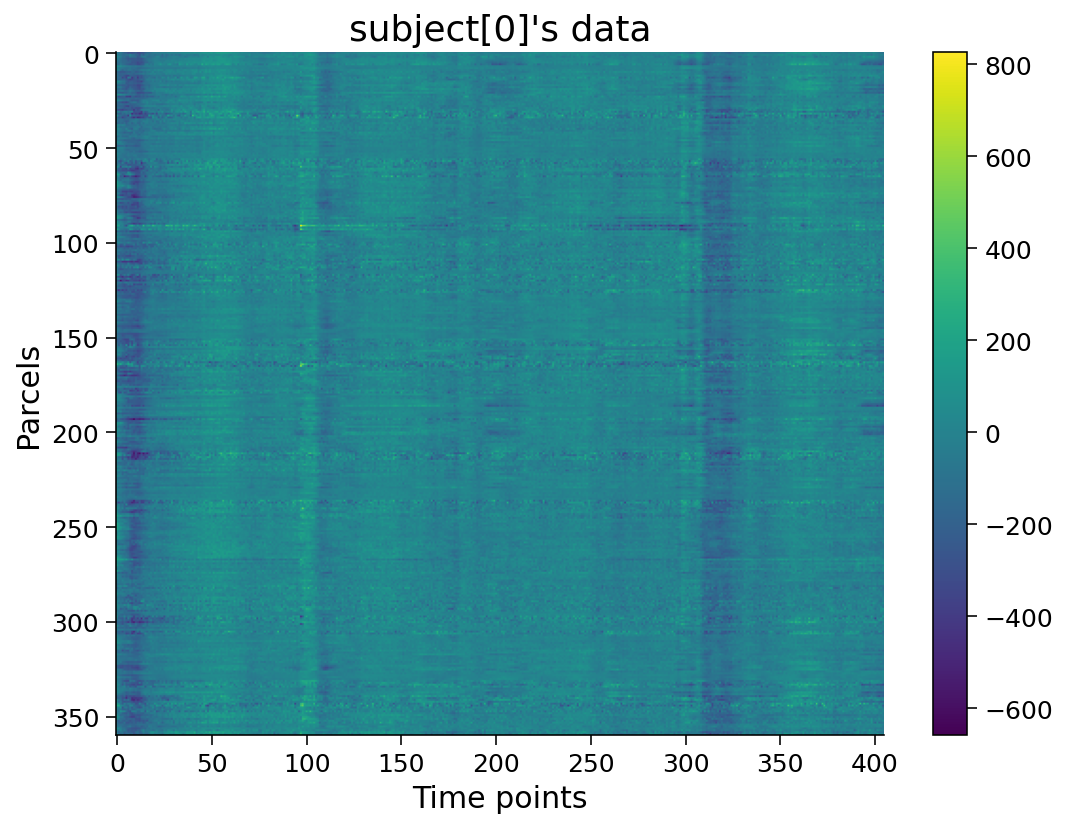

In [13]:
import matplotlib.pyplot as plt
plt.title("subject[0]'s data")
plt.xlabel('Time points')
plt.ylabel('Parcels')
image = plt.imshow(timeseries)
plt.colorbar()
plt.show

In [14]:
timeseries_WM = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "WM")
  timeseries_WM.append(ts_concat)

##Making the big Array for all of the Subjects (We won't use this for the deep learning, only for visualization)

In [15]:
N_TIMEPOINTS = 405
data = [None]*N_SUBJECTS
for i in range(N_SUBJECTS):
  timeseries = load_timeseries(subject=i, name="WM", runs=1) # n_parcel x n_timepoint
  data[i] = timeseries
# print(data)

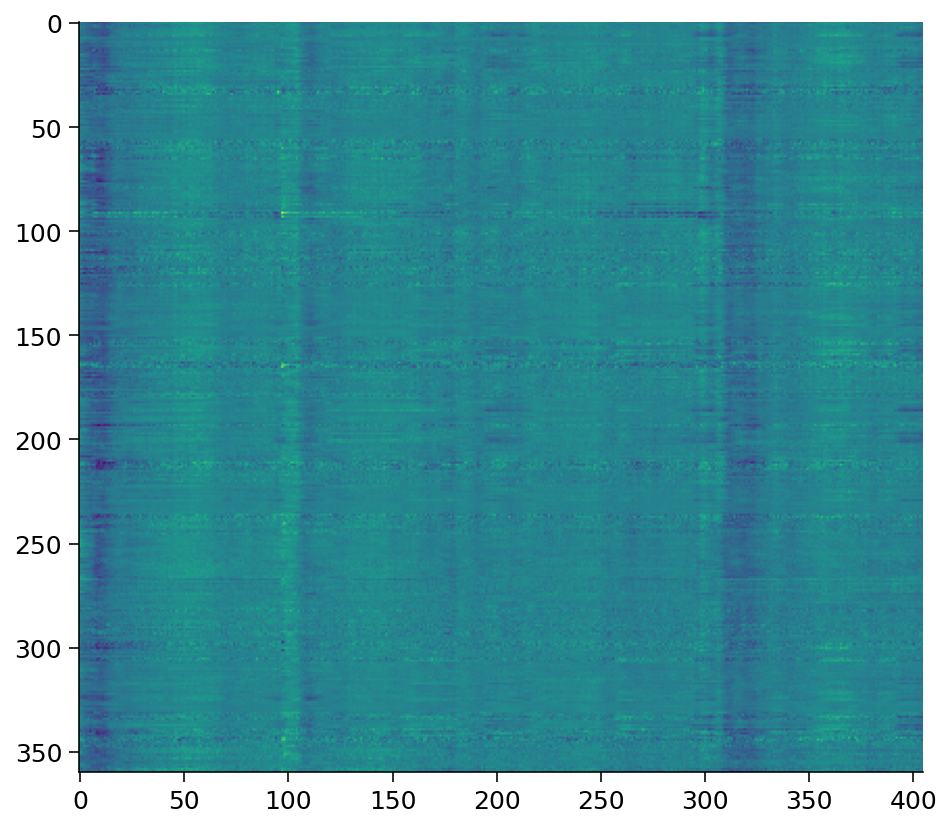

In [16]:
plt.imshow(data[0])

In [17]:
specific_data = get_condition_bold(subject=0, task='WM', condition='0bk_faces', run=1, task_bold_timeseries=data[0])

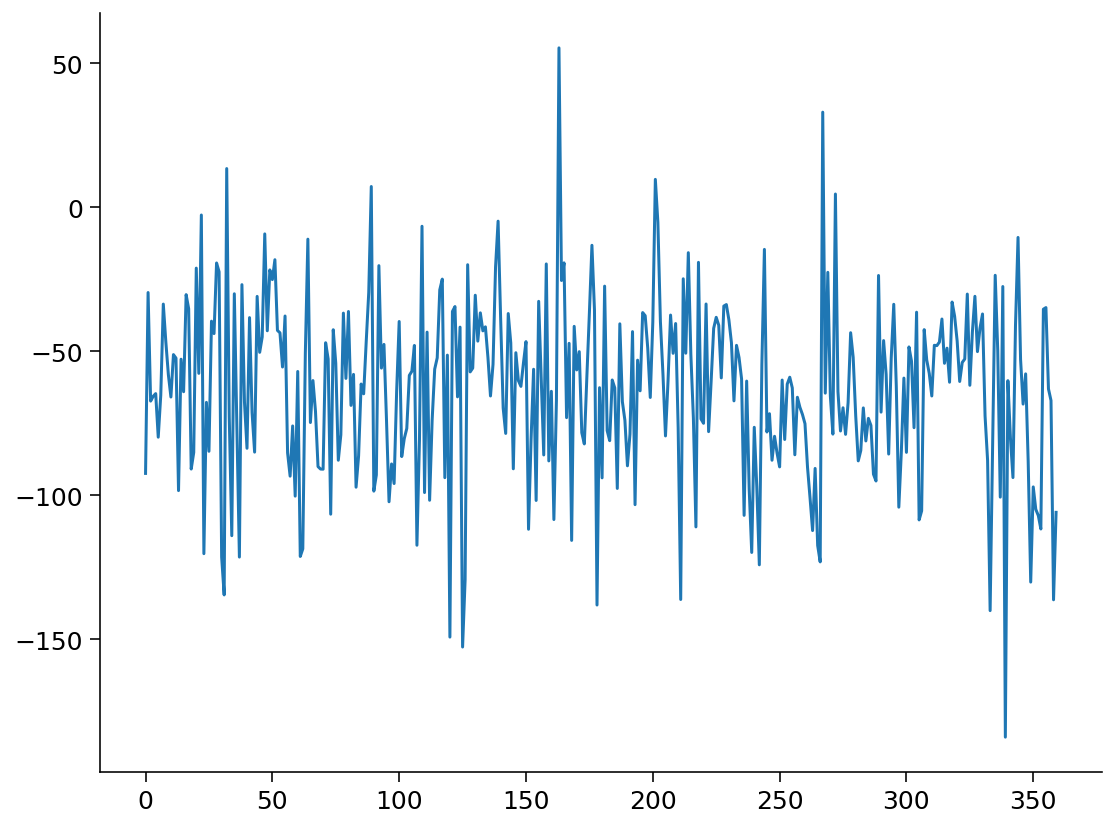

In [18]:
plt.plot(specific_data)


In [19]:
class_names = ["body", "faces", "places", "tools"] # 0,1,2,3  but we won't use this array

#Build the 70:30 Mixture Fraction for run0, run1, and the mix data sets (training and test sets)

In [20]:
from sklearn.model_selection import cross_val_score, train_test_split
# Homero
def load_subjects_timeseries(from_originals=False):
    # if from_originals:
    ts_wm_subjs = []
    for subj in list(subjects):
            ts_wm_subjs.append(load_timeseries(subj, 'wm', concat=True, remove_mean=True))
    # else:
    #     with open(os.path.join(HCP_DIR, "ts_wm_subjs.pkl"), 'rb') as f:
    #         ts_wm_subjs = pickle.load(f)
    # print("Subjects timeseries loaded.")
    return ts_wm_subjs

ts_wm_subjs = load_subjects_timeseries()

X_run0 = np.empty((N_SUBJECTS*8, N_PARCELS))
run = 0
for subj in list(subjects)*8:
    X_run0[subj, :] = get_condition_bold(subj,'wm','2bk_faces', run, ts_wm_subjs[subj])
    X_run0[N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_faces', run, ts_wm_subjs[subj])
    X_run0[2*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_tools', run, ts_wm_subjs[subj])
    X_run0[3*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_tools', run, ts_wm_subjs[subj])
    X_run0[4*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_places', run, ts_wm_subjs[subj])
    X_run0[5*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_places', run, ts_wm_subjs[subj])
    X_run0[6*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_body', run, ts_wm_subjs[subj])
    X_run0[7*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_body', run, ts_wm_subjs[subj])

X_run1 = np.empty((N_SUBJECTS*8, N_PARCELS))
run = 1
for subj in list(subjects)*8:
    X_run1[subj, :] = get_condition_bold(subj,'wm','2bk_faces', run, ts_wm_subjs[subj])
    X_run1[N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_faces', run, ts_wm_subjs[subj])
    X_run1[2*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_tools', run, ts_wm_subjs[subj])
    X_run1[3*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_tools', run, ts_wm_subjs[subj])
    X_run1[4*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_places', run, ts_wm_subjs[subj])
    X_run1[5*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_places', run, ts_wm_subjs[subj])
    X_run1[6*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_body', run, ts_wm_subjs[subj])
    X_run1[7*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_body', run, ts_wm_subjs[subj])

print("Finished separating BOLD signal using the task blocks.")

y_run0 = np.concatenate(([0]*N_SUBJECTS*2,[1]*N_SUBJECTS*2,[2]*N_SUBJECTS*2,[3]*N_SUBJECTS*2))
y_run1 = np.copy(y_run0)

X_run0_train, X_run0_test, y_run0_train, y_run0_test  = train_test_split(X_run0, y_run0)
X_run1_train, X_run1_test, y_run1_train, y_run1_test  = train_test_split(X_run1, y_run1)

X = np.concatenate([X_run0_train, X_run1_train])
y = np.concatenate([y_run0_train, y_run1_train])

Finished separating BOLD signal using the task blocks.


In [21]:
X_mix = np.concatenate((X_run0_train, X_run1_train, X_run0_test, X_run1_test))
y_mix = np.concatenate((y_run0_train, y_run1_train, y_run0_test, y_run1_test))
X_mix_train, X_mix_test, y_mix_train, y_mix_test = train_test_split(X_mix, y_mix)

In [ ]:
X_mix_train.shape

(4068, 360)

In [ ]:
y_run0_train.shape

(2034,)

#Build the Neural Network

In [22]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.3.0


In [23]:
model = keras.Sequential([
    # keras.layers.Flatten(input_shape=(360)),
    keras.layers.Dense(360, input_dim=360),
    keras.layers.Dense(1000, activation='relu'), #activation function: relu, logistic
    keras.layers.Dense(4)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

##Feed The Model

choose the training sets (run0, run1, mix), make sure to include X (data) and y (labels), epochs is the number of times the model is trained with the date, please look how the accuracy increases as we repeatedly trian the model.

In [25]:
model.fit(X_run0_train, y_run0_train, epochs=50) ##Must define train_labels ==> what is the label for each data

Epoch 1/50
64/64 [==============================] - 0s 6ms/step - loss: 20.3509 - accuracy: 0.7434
Epoch 2/50
64/64 [==============================] - 0s 7ms/step - loss: 9.2062 - accuracy: 0.9061
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 7.3685 - accuracy: 0.9317
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 4.9763 - accuracy: 0.9538
Epoch 5/50
64/64 [==============================] - 0s 6ms/step - loss: 2.2025 - accuracy: 0.9641
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 1.3151 - accuracy: 0.9784
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 1.5980 - accuracy: 0.9705
Epoch 8/50
64/64 [==============================] - 0s 6ms/step - loss: 3.5847 - accuracy: 0.9582
Epoch 9/50
64/64 [==============================] - 0s 6ms/step - loss: 1.5429 - accuracy: 0.9715
Epoch 10/50
64/64 [==============================] - 0s 6ms/step - loss: 2.0134 - accuracy: 0.9784
Epoch 11/50
64/64 

##The accuracy with test sets (with run0, run1 and mix)

In [27]:
test_loss, test_acc = model.evaluate(X_mix_test,  y_mix_test, verbose=2)

print('\nTest accuracy:', test_acc)

43/43 - 0s - loss: 229.4930 - accuracy: 0.5634

Test accuracy: 0.5634218454360962


In [26]:
test_loss, test_acc = model.evaluate(X_run0_test,  y_run0_test, verbose=2)

print('\nTest accuracy:', test_acc)

22/22 - 0s - loss: 9.3749 - accuracy: 0.9307

Test accuracy: 0.9306784868240356


In [28]:
test_loss, test_acc = model.evaluate(X_run1_test,  y_run1_test, verbose=2)

22/22 - 0s - loss: 464.3915 - accuracy: 0.1180


In [ ]:
run0_training = 1
run0_train_run0_test = 0.94
run0_train_run1_test = 0.14
run0_train_mix_test = 0.55


run1_training= 0.98
run1_train_run0_test = 0.14
run1_train_run1_test = 0.85
run1_train_mix_test = 0.54

mix_training = 0.49
mix_train_run0_test = 0.44
mix_train_run1_test = 0.55
mix_train_mix_test = 0.46


##Plotting the results

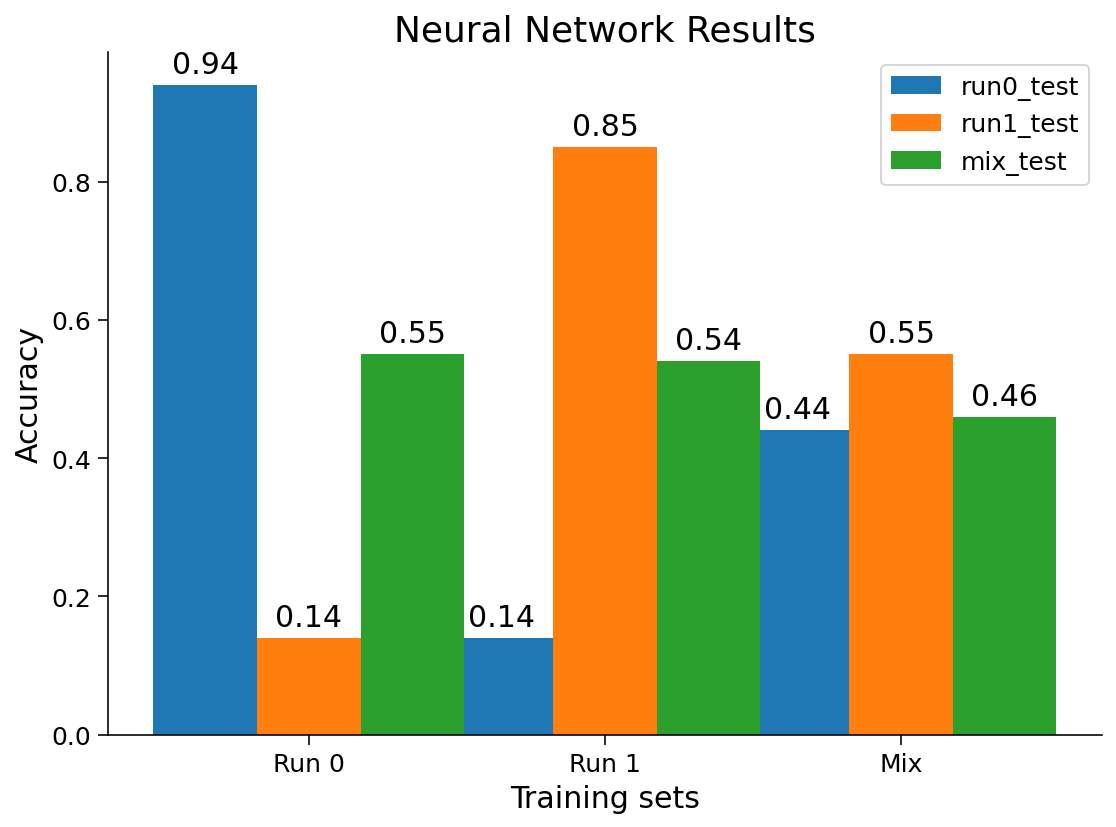

In [ ]:
run0_training = 1
run0_train_run0_test = 0.94
run0_train_run1_test = 0.14
run0_train_mix_test = 0.55


run1_training= 0.98
run1_train_run0_test = 0.14
run1_train_run1_test = 0.85
run1_train_mix_test = 0.54

mix_training = 0.49
mix_train_run0_test = 0.44
mix_train_run1_test = 0.55
mix_train_mix_test = 0.46

import matplotlib.pyplot as plt
import numpy as np


labels = ['Run 0', 'Run 1', 'Mix']
run0_test = [run0_train_run0_test, run1_train_run0_test, mix_train_run0_test]
run1_test = [run0_train_run1_test, run1_train_run1_test, mix_train_run1_test]
mix_test = [run0_train_mix_test, run1_train_mix_test, mix_train_mix_test]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, run0_test, width, label='run0_test')
rects2 = ax.bar(x , run1_test, width, label='run1_test')
rects3 = ax.bar(x + width, mix_test, width, label='mix_test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Training sets')
ax.set_title('Neural Network Results')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


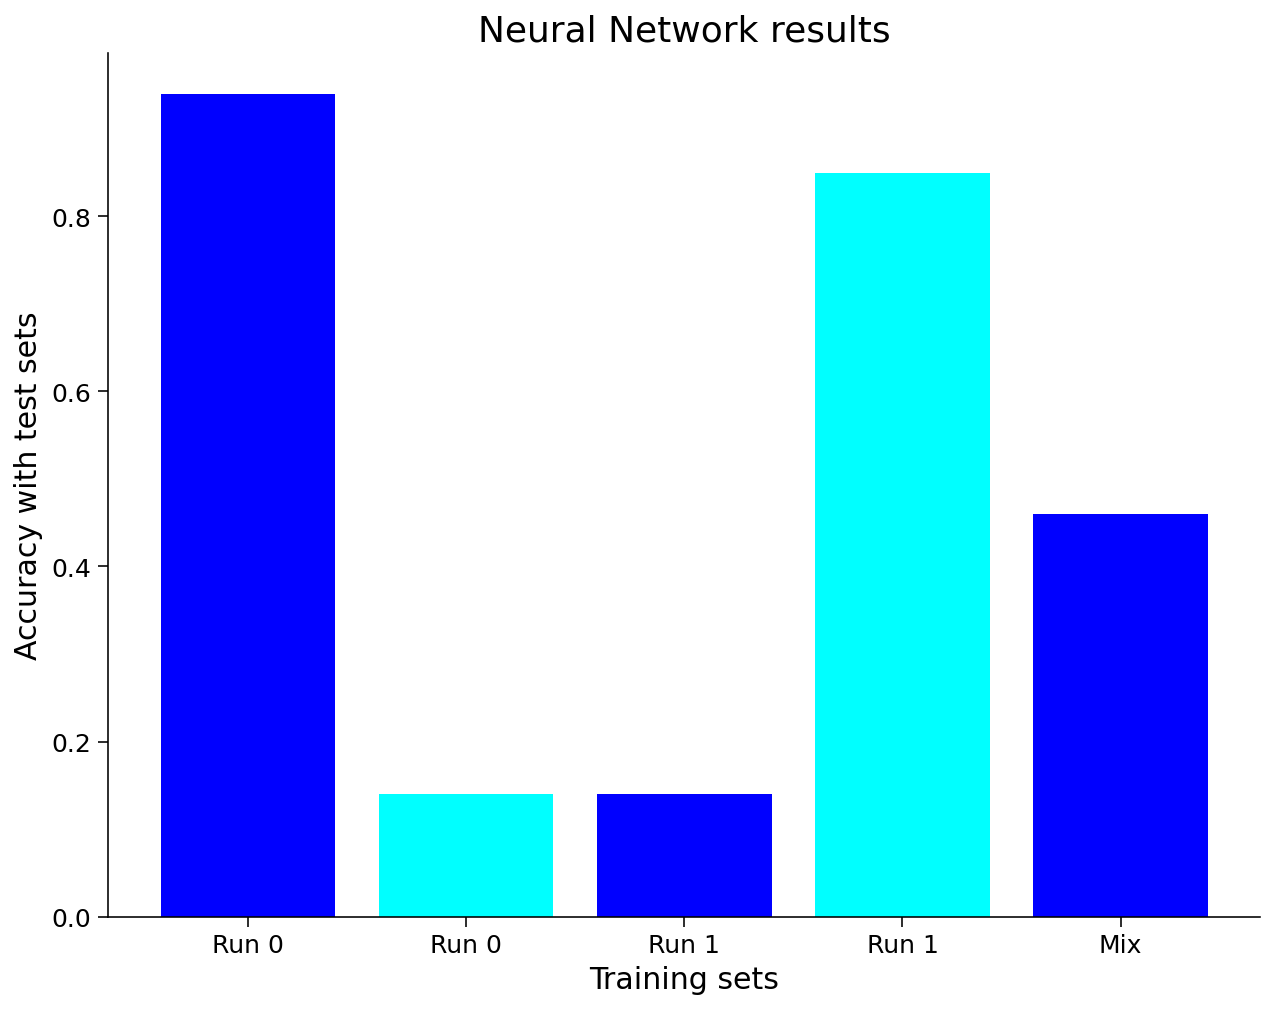

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [run0_train_run0_test, run0_train_run1_test, run1_train_run0_test, run1_train_run1_test, mix_train_mix_test]
  
# labels for bars 
tick_label = ['Run 0', 'Run 0', 'Run 1', 'Run 1', 'Mix'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['blue', 'cyan']) 
  
# naming the x-axis 
plt.xlabel('Training sets') 
# naming the y-axis 
plt.ylabel('Accuracy with test sets') 
# plot title 
plt.title('Neural Network results') 
  
# function to show the plot 
plt.show() 